In [27]:
import os

import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

use_cuda = True

Plot the results

In [44]:
def plot_fit_history(history_plt):
  tr_acc = history_plt['acc']
  val_acc = history_plt['val_acc']
  tr_loss = history_plt['loss']
  val_loss = history_plt['val_loss']
  epochs_range = range(1, len(tr_acc) + 1)
  fig, ax1 = plt.subplots()

  color = 'tab:red'
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss', color=color)
  l1, = ax1.plot(epochs_range, tr_loss, 's:', color=color, label='Training Loss', markeredgewidth=1, fillstyle='none')
  l2, = ax1.plot(epochs_range, val_loss, 'o-', color=color, label='Validation Loss')
  ax1.tick_params(axis='y', labelcolor=color, grid_color=color, grid_linestyle=':')

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  color = 'tab:blue'
  ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
  l3, = ax2.plot(epochs_range, tr_acc, 's:', color=color, label='Training Acc', markeredgewidth=1, fillstyle='none')
  l4, = ax2.plot(epochs_range, val_acc, 'o-', color=color, label='Validation Acc')
  ax2.tick_params(axis='y', labelcolor=color, grid_color=color, grid_linestyle=':')

  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  
  plt.legend((l1, l2, l3, l4), ('Training Loss', 'Validation Loss', 'Training Acc', 'Validation Acc'), loc=(1.2,0.5))
  plt.show()

Files will be loaded now. The data file contains lines of notes ("songs") separated by newline characters.

In [29]:
class DataSet:
  def __init__(self, songs):
    # list of songs
    self.s = songs
    # number of notes in each song
    self.n_s = []
    for s0 in songs:
      self.n_s.append(s0.shape[0])
    self.n_s = np.array(self.n_s)
    # total number of notes in all songs
    self.n_t = self.n_s.sum()
    # number of songs
    self.n_n = len(self.s)
    # all nodes as one sequence
    self.orig_data = np.concatenate(self.s)

# list of all songs from the datafile
s = []

with open('/content/drive/My Drive/Colab Notebooks/music.txt') as fp:
  for cnt, line in enumerate(fp):
    s0 = np.fromstring(line, sep=" ", dtype=int)
    s.append(s0)

full_set = DataSet(s)

print(full_set.n_t)

print(full_set.orig_data.shape)

1553149
(1553149,)


Data preprocessing

In [30]:
data_dict = np.unique(full_set.orig_data);

dim = len(data_dict)

# class label to class index mapping
label_to_int = dict((l, i) for i, l in enumerate(data_dict))

# one-hot encoding from class indices
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[targets]
    return res.reshape(list(targets.shape)+[nb_classes])

# encoding full DataSet
# by adding new attributes to the data structure
full_set.int_s = []
full_set.one_hot_s = []
for s0 in full_set.s:
  int_tmp = np.array([label_to_int[l] for l in s0], dtype=int)
  # data as class indices
  full_set.int_s.append(int_tmp)
  # data as one-hot vectors
  full_set.one_hot_s.append(get_one_hot(int_tmp, dim))

print(full_set.one_hot_s[0].shape)

(1004, 89)


Total there are 740 songs. First 80 songs are taken as validation set and the rest is training set

In [31]:
n_validation_songs = 80

val_d = DataSet(s[0:n_validation_songs])
val_d.int_s = full_set.int_s[0:n_validation_songs]
val_d.one_hot_s = full_set.one_hot_s[0:n_validation_songs]

tr_d =  DataSet(s[n_validation_songs:])
tr_d.int_s = full_set.int_s[n_validation_songs:]
tr_d.one_hot_s = full_set.one_hot_s[n_validation_songs:]

In [32]:
print(val_d.one_hot_s[0].shape)

(1004, 89)


In [33]:
batch = 64
timelapse = 32

def generator(data, b=batch, t=timelapse):
  n_t_p = data.n_t - data.n_n*(t+1)
  n_s_p = data.n_s - (t+1)
  while True:
    samples = np.zeros((b, t, dim))
    targets = np.zeros((b)) 
    for k in range (b):
      i = random.randrange(0, n_t_p)
      j = 0;
      while i >= n_s_p[j]:
         i -= n_s_p[j]
         j += 1
      samples[k] = data.one_hot_s[j][i:i+t]
      targets[k] = data.int_s[j][i+t]

    yield samples, targets

We are using a 2 layered LSTM model.

In [34]:
class Model(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=2):
        super(Model, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.hidden = self.init_hidden()

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the dense layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        lstm_out, self.hidden = self.lstm(input.view(-1, self.batch_size, self.input_dim))
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred

In [35]:
sample_size = tr_d.n_t - timelapse*tr_d.n_n
val_size = val_d.n_t - timelapse*val_d.n_n

h_dim = 512
model = Model(dim, h_dim, batch, dim, 2)
if use_cuda and torch.cuda.is_available():
    model.cuda()

In [36]:
learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss()
optimiser = optim.RMSprop(model.parameters(), lr=learning_rate)

In [37]:
hist = {"acc": [], "loss": [], "val_loss": [], "val_acc": []}


def train(num_epochs, tr_gen, val_gen):
  for t in range(num_epochs):
    correct = 0
    total = 0
    for b1 in range(0, sample_size, batch*timelapse):
      
      # Clear stored gradient
      model.zero_grad()
      optimiser.zero_grad()

      # Forward pass
      x_batch, y_batch = next(tr_gen)
      x_batch = torch.from_numpy(np.swapaxes(x_batch, 0, 1)).float()
      y_batch = torch.from_numpy(y_batch).long()
      if use_cuda and torch.cuda.is_available():
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()
      y_pred = model(x_batch)
      _, predicted = torch.max(y_pred.data, 1)
      labels = y_batch
      correct += (predicted.cpu() == labels.cpu()).sum()
      total += labels.size(0)
      loss = loss_fn(y_pred, y_batch)
      if b1 == 0:
        # print(y_pred.shape)
        print("Epoch ", t, "Loss: ", loss.item())
      currloss = loss.item()

      # Backward pass
      loss.backward()

      # Update parameters
      optimiser.step()
    
    accuracy = 100 * correct.item() / total
    hist["loss"].append(currloss)
    hist["acc"].append(accuracy)
    print("acc: ", accuracy)

    # Validation
    correct = 0
    total = 0
    loss = 0
    n_b = 0
    with torch.no_grad():
      for b in range(0, val_size, batch*timelapse):
        x_batch, y_batch = next(val_gen)
        x_batch = torch.from_numpy(np.swapaxes(x_batch, 0, 1)).float()
        y_batch = torch.from_numpy(y_batch).long()
        if use_cuda and torch.cuda.is_available():
          x_batch = x_batch.cuda()
          y_batch = y_batch.cuda()
        y_pred = model(x_batch)
        _, predicted = torch.max(y_pred.data, 1)
        labels = y_batch
        correct += (predicted.cpu() == labels.cpu()).sum()
        total += labels.size(0)
        loss += loss_fn(y_pred, y_batch)
        n_b += 1
      accuracy = 100 * correct.item() / total
      loss = loss.item() / n_b 
    hist["val_loss"].append(loss)
    hist["val_acc"].append(accuracy)
    print("Val acc: ", accuracy, "Val loss: ", loss)

In [38]:
gen = generator(tr_d)
vgen = generator(val_d)

In [39]:
train(80, gen, vgen)

Epoch  0 Loss:  4.481044292449951
acc:  3.42966573816156
Val acc:  3.4375 Val loss:  3.7486368815104165
Epoch  1 Loss:  3.874610424041748
acc:  3.7212743732590527
Val acc:  3.3854166666666665 Val loss:  3.720936584472656
Epoch  2 Loss:  3.9086477756500244
acc:  4.754961699164346
Val acc:  5.15625 Val loss:  3.548292032877604
Epoch  3 Loss:  3.7313098907470703
acc:  6.241295264623956
Val acc:  6.770833333333333 Val loss:  3.43245366414388
Epoch  4 Loss:  3.597437858581543
acc:  7.671048050139276
Val acc:  9.114583333333334 Val loss:  3.3529637654622397
Epoch  5 Loss:  3.481365442276001
acc:  9.483809192200557
Val acc:  9.479166666666666 Val loss:  3.2607243855794272
Epoch  6 Loss:  3.207350730895996
acc:  10.702472144846796
Val acc:  11.614583333333334 Val loss:  3.2068585713704425
Epoch  7 Loss:  3.3116676807403564
acc:  12.019063370473537
Val acc:  11.510416666666666 Val loss:  3.2070164998372395
Epoch  8 Loss:  3.111017942428589
acc:  13.368297353760445
Val acc:  13.385416666666666 V

In [40]:
for param_group in optimiser.param_groups:
        param_group['lr'] = learning_rate/3
train(25, gen, vgen)

Epoch  0 Loss:  1.8731138706207275
acc:  47.27541782729805
Val acc:  23.28125 Val loss:  2.803538513183594
Epoch  1 Loss:  1.8555808067321777
acc:  48.72040389972145
Val acc:  25.052083333333332 Val loss:  2.7873138427734374
Epoch  2 Loss:  2.3789432048797607
acc:  49.188283426183844
Val acc:  25.520833333333332 Val loss:  2.752007802327474
Epoch  3 Loss:  1.706709623336792
acc:  49.701862813370475
Val acc:  23.541666666666668 Val loss:  2.8109469095865887
Epoch  4 Loss:  1.8886009454727173
acc:  50.2916086350975
Val acc:  24.114583333333332 Val loss:  2.789398447672526
Epoch  5 Loss:  1.9649107456207275
acc:  50.470055710306404
Val acc:  23.541666666666668 Val loss:  2.7858248392740887
Epoch  6 Loss:  1.622462272644043
acc:  50.97275417827298
Val acc:  25.052083333333332 Val loss:  2.7604698181152343
Epoch  7 Loss:  1.9321367740631104
acc:  51.40146239554318
Val acc:  25.729166666666668 Val loss:  2.768787384033203
Epoch  8 Loss:  1.9177192449569702
acc:  51.65607590529248
Val acc:  2

In [41]:
for param_group in optimiser.param_groups:
        param_group['lr'] = learning_rate/9
train(25, gen, vgen)

Epoch  0 Loss:  1.729005217552185
acc:  55.65372562674095
Val acc:  24.270833333333332 Val loss:  2.8470136006673177
Epoch  1 Loss:  1.7728588581085205
acc:  56.49373259052925
Val acc:  24.479166666666668 Val loss:  2.787554931640625
Epoch  2 Loss:  1.3776943683624268
acc:  56.58730849582173
Val acc:  24.010416666666668 Val loss:  2.846393585205078
Epoch  3 Loss:  1.7565683126449585
acc:  56.51114206128134
Val acc:  25.260416666666668 Val loss:  2.8153658548990887
Epoch  4 Loss:  1.8498961925506592
acc:  56.8549791086351
Val acc:  24.895833333333332 Val loss:  2.835796101888021
Epoch  5 Loss:  1.5883123874664307
acc:  57.38379178272981
Val acc:  24.0625 Val loss:  2.8171002705891928
Epoch  6 Loss:  1.3858168125152588
acc:  58.223798746518106
Val acc:  23.958333333333332 Val loss:  2.8161822001139325
Epoch  7 Loss:  1.6459298133850098
acc:  57.57529596100279
Val acc:  25.364583333333332 Val loss:  2.7885220845540366
Epoch  8 Loss:  1.7482150793075562
acc:  57.69280988857939
Val acc:  24

In [46]:
for param_group in optimiser.param_groups:
        param_group['lr'] = learning_rate/27
train(25, gen, vgen)

Epoch  0 Loss:  1.5538440942764282
acc:  60.030031337047355
Val acc:  22.864583333333332 Val loss:  2.8476153055826825
Epoch  1 Loss:  1.308781623840332
acc:  59.79935584958217
Val acc:  23.697916666666668 Val loss:  2.8844395955403646
Epoch  2 Loss:  1.3265432119369507
acc:  60.36516364902507
Val acc:  24.166666666666668 Val loss:  2.8932706197102864
Epoch  3 Loss:  1.3349405527114868
acc:  60.38039693593315
Val acc:  23.90625 Val loss:  2.909354654947917
Epoch  4 Loss:  1.5555471181869507
acc:  60.31728760445682
Val acc:  25.46875 Val loss:  2.8619099934895833
Epoch  5 Loss:  1.3949347734451294
acc:  60.706824512534816
Val acc:  24.479166666666668 Val loss:  2.9290898640950522
Epoch  6 Loss:  1.4573570489883423
acc:  61.17688022284123
Val acc:  23.4375 Val loss:  2.9773790995279947
Epoch  7 Loss:  1.0543276071548462
acc:  60.687238857938716
Val acc:  24.53125 Val loss:  2.8776212056477863
Epoch  8 Loss:  1.5934693813323975
acc:  60.69159122562674
Val acc:  27.65625 Val loss:  2.75239

In [48]:
for param_group in optimiser.param_groups:
        param_group['lr'] = learning_rate/81
train(25, gen, vgen)

Epoch  0 Loss:  1.322782278060913
acc:  61.858025766016716
Val acc:  23.958333333333332 Val loss:  2.944024658203125
Epoch  1 Loss:  1.498641848564148
acc:  61.76009749303621
Val acc:  24.583333333333332 Val loss:  2.910088857014974
Epoch  2 Loss:  1.4566476345062256
acc:  61.21822771587744
Val acc:  23.958333333333332 Val loss:  2.9279050191243488
Epoch  3 Loss:  1.1168828010559082
acc:  61.92766364902507
Val acc:  22.708333333333332 Val loss:  2.943163299560547
Epoch  4 Loss:  1.4523355960845947
acc:  62.23668175487465
Val acc:  25.052083333333332 Val loss:  2.883373514811198
Epoch  5 Loss:  1.5245578289031982
acc:  61.940720752089135
Val acc:  25.260416666666668 Val loss:  2.847063446044922
Epoch  6 Loss:  1.1884918212890625
acc:  62.0125348189415
Val acc:  23.90625 Val loss:  2.899588775634766
Epoch  7 Loss:  1.2389743328094482
acc:  61.94724930362117
Val acc:  24.427083333333332 Val loss:  2.8992818196614585
Epoch  8 Loss:  1.951547622680664
acc:  61.640407381615596
Val acc:  24.6

In [50]:
for param_group in optimiser.param_groups:
        param_group['lr'] = learning_rate/243
train(25, gen, vgen)

Epoch  0 Loss:  1.7842508554458618
acc:  61.84932103064067
Val acc:  21.770833333333332 Val loss:  2.9678009033203123
Epoch  1 Loss:  1.150941014289856
acc:  61.901549442896936
Val acc:  22.708333333333332 Val loss:  2.981287129720052
Epoch  2 Loss:  1.3207858800888062
acc:  61.96683495821727
Val acc:  23.802083333333332 Val loss:  2.9584228515625
Epoch  3 Loss:  1.4337856769561768
acc:  62.35201949860724
Val acc:  24.0625 Val loss:  3.011061350504557
Epoch  4 Loss:  1.4418821334838867
acc:  61.960306406685234
Val acc:  23.125 Val loss:  2.9362202962239583
Epoch  5 Loss:  1.5871052742004395
acc:  61.949425487465184
Val acc:  25.572916666666668 Val loss:  2.912506357828776
Epoch  6 Loss:  1.429781198501587
acc:  62.169220055710305
Val acc:  22.291666666666668 Val loss:  3.0262451171875
Epoch  7 Loss:  1.1731677055358887
acc:  62.21709610027855
Val acc:  21.09375 Val loss:  2.995799255371094
Epoch  8 Loss:  1.321407675743103
acc:  62.24756267409471
Val acc:  23.4375 Val loss:  2.91794865

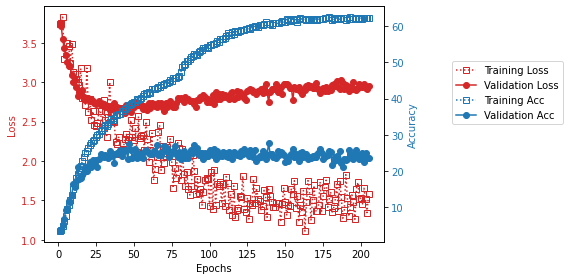

In [51]:
plot_fit_history(hist)
